<a href="https://colab.research.google.com/github/davidepelliciari/statistics/blob/master/imp_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A-posteriori probe combination using importance sampling**

In this notebook we show how to perform importance sampling on two cosmological probes. We are going to use BAO MCMC chains from Cooke et al. 2017, and WMAP MCMC chains and we're going to consider 4 cosmological parameters:

$\vec{\theta} = (\Omega_bh^2, h, \Omega_\Lambda, \Omega_m)$

This importance sampler reads points from one chain and then weights them according to the importance sampling rule (see later). In order to do this one needs $\chi^2_x$ (or $log P_x = -0.5 \chi^2_x$, where $P$ is the posterior distribution of probe $x$) at that points from the other chain's data. We're gonna interpolate that using the CosmoBolognaLib's class **Chain Mesh**.
Consequently one needs to importance sampling chain2 with chain1 and at the end concatenates the resulting chains.

# Set the Environment 

## Import standard Python modules required for the analysis

In [ ]:
from scipy.spatial import Voronoi
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.interpolate
import scipy.spatial
from zipfile import ZipFile
import time
!pip install corner
import corner

# https://docs.python.org/3/library/sys.html
import sys

# https://docs.python.org/3/library/urllib.html
import urllib.request as request
from urllib.request import urlopen

# https://docs.python.org/3/library/io.html
from io import BytesIO


## Mount the Google Drive home directory

In [ ]:
# Mount Google Drive home
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Get the CosmoBolognaLib and compile, to get the Python wrapper

We will make use of the CosmoBolognaLib (https://arxiv.org/pdf/1511.00012.pdf) to manage posterior distributions using Chain Mesh. The CosmoBolognaLib is a large set of free software C++/Python libraries for cosmological calculations, available at the following GitLab repository: https://gitlab.com/federicomarulli/CosmoBolognaLib.

In [ ]:
# Get the CosmoBolognaLib
!pip install --index-url https://test.pypi.org/simple/ --no-deps Manage_CosmoBolognaLib

# Import the module to compile the CosmoBolognaLib
from Manage_CosmoBolognaLib.managecbl import ManageCosmoBolognaLib as mc

# First initialize the environment
# the constructor install (if necessary) all the required dependencies
getCBL = mc()

# The call operator search for an existing installation of the CosmoBolognaLib (in form of .tar.gz)
# at path root_dir+CBL_file+.tar.gz.
# If the file root_dir+CBL_file+.tar.gz exists, it is copied in the /content/CosmoBolognaLib folder and extracted
# If the file root_dir+CBL_file+.tar.gz doesn't exists, the CosmoBolognaLib repository is cloned and the libraries
# compiled. The results is then compressed and sent to root_dir.
if not os.path.isdir("/content/CosmoBolognaLib/"):
  getCBL(CBL_file="CosmoBolognaLib", root_dir="/content/drive/My Drive", branch="develop")
else:
  getCBL.pull()
  getCBL.compile()
  #getCBL.send_tar_to_drive(CBL_file="CosmoBolognaLib", root_dir="/content/drive/My Drive")

Looking in indexes: https://test.pypi.org/simple/
libgfortran3 already installed
libgsl-dev already installed
libgsl23 already installed
libgslcblas0 already installed
libfftw3-dev already installed
libboost-all-dev already installed
libcfitsio5 already installed
libcfitsio-dev already installed
swig3.0 already installed
cython already installed
CosmoBolognaLib succesfully added to the PYTHONPATH!
You can now use the CosmoBolognaLib using the import command.
Already up to date.
make Eigen
g++ -shared -o /content/CosmoBolognaLib/libCBL.so /content/CosmoBolognaLib/Kernel/Kernel.o /content/CosmoBolognaLib/Wrappers/EigenWrapper.o /content/CosmoBolognaLib/Wrappers/GSLwrapper.o /content/CosmoBolognaLib/Wrappers/CUBAwrapper.o /content/CosmoBolognaLib/Wrappers/FITSwrapper.o  /content/CosmoBolognaLib/FuncGrid/FuncGrid.o /content/CosmoBolognaLib/FuncGrid/FuncGrid_Bspline.o /content/CosmoBolognaLib/External/fftlog-f90-master/drffti.o /content/CosmoBolognaLib/External/fftlog-f90-master/drfftb.o /c

### Import the CosmoBolognaLib

In [ ]:
import CosmoBolognaLib as cbl
cbl.SetDirs("/content/CosmoBolognaLib/", "/content/")

AttributeError: ignored

## Set the I/O data

In [ ]:
# Set the directory where the data will be stored. This can improve performances 
save_dir = "/content/drive/My Drive/Colab Notebooks/Probe_Combination/"

# Set the directory where the chains will be stored (both input and output)
chain_dir = save_dir+"/chains/"

# Set the name of the chains
file_A = "BAO_Cooke17.dat"
file_B = "WMAP.dat"

# Set the directory where the plots will be stored
plot_dir = save_dir+"plots/"

# Create all the directories
os.makedirs(chain_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

## Read the chains and set the parameter for the analysis

In [ ]:
# the fist N columns are the parameters, the last column is the chi2
chain_A = np.genfromtxt(chain_dir+file_A, usecols={0,1,2,3,4}, unpack=True)

chain_B = np.genfromtxt(chain_dir+file_B, usecols={0,1,2,3,4}, unpack=True)

# number of steps in each chain
len_chain_A = len(chain_A[0])
len_chain_B = len(chain_B[0])

# number of parameters in the chain
nparams = len(chain_A)-1

print("Lunghezza chain_A: ",len_chain_A)
print("Lunghezza chain_B: ",len_chain_B)
print("Numero di parametri selezionati: ", len(chain_A))

Lunghezza chain_A:  23123
Lunghezza chain_B:  46064
Numero di parametri selezionati:  5


# Computing $\log Post_x$ from $\chi^2_x$ distributions



In [ ]:
logpost_A = [0. for i in range(len_chain_A)]
logpost_B = [0. for i in range(len_chain_B)]

for i in range(len_chain_A):
    logpost_A[i] = -0.5*chain_A[nparams][i]

for i in range(len_chain_B):
    logpost_B[i] = -0.5*chain_B[nparams][i]

print("Min of logpost_A: ", np.min(logpost_A))
print("Max of logpost_A: ", np.max(logpost_A))
print("Min of logpost_B: ", np.min(logpost_B))
print("Max of logpost_B: ", np.max(logpost_B))

Min of logpost_A:  -9.181055
Max of logpost_A:  -5.848645e-11
Min of logpost_B:  -3792.234
Max of logpost_B:  -3779.0425


#Set the chain mesh

## Set the internal parameters for Chain Mesh

In [ ]:
# number of interval per axes
dim_grid = 150

# cell size dimension
cell_size = 200./dim_grid;

# searching radius for Chain Mesh
rMAX = 3.

# maximum numbers of cell
nMAX = dim_grid**2

# average on the distNum closest points
distNum = 500

## Rescale chains and initialize the computed logposteriors

In [ ]:
chainAB = [list(chain_A[N])+list(chain_B[N]) for N in range(nparams+1)]
chainBA = [list(chain_B[N])+list(chain_A[N]) for N in range(nparams+1)]

# logposterior_x calculated in the same points of y
logP_B_pointsA = []
logP_A_pointsB = []

min_logpost_A = np.min(logpost_A)
min_logpost_B = np.min(logpost_B)

logP_B_pointsA = [min_logpost_B for i in range(len_chain_A)]
logP_A_pointsB = [min_logpost_A for i in range(len_chain_B)]

# rescale chains between -100 and 100 in order to have a squared chain mesh
for nn in range(nparams):

  deltaAB = max(chainAB[nn])-min(chainAB[nn])
  minAB = min(chainAB[nn])
  chainAB[nn] = [200./(deltaAB)*(chainAB[nn][ii]-minAB)-100. for ii in range(len_chain_A+len_chain_B)]

  deltaBA = max(chainBA[nn])-min(chainBA[nn])
  minBA = min(chainBA[nn])
  chainBA[nn] = [200./(deltaBA)*(chainBA[nn][ii]-minBA)-100. for ii in range(len_chain_B+len_chain_A)]

# Do the chain mesh for BAO_Cooke17+WMAP

Computing the logposterior of WMAP in the same points of BAO_Cooke17 (AB case)


In [ ]:
# initialize Chain Mesh
ChM = cbl.ChainMesh(cell_size,nparams)

# create the chain mesh
ChM.create_chain_mesh(chainAB, rMAX, 0, nMAX)

# loop over the points of chain_A
for jj in range(len_chain_A):

  # points of chain_A will be the center from which we search nearest points in the other chain
  centre = [chainAB[nn][jj] for nn in range(nparams)]

  # find the closest points near current centre
  close = ChM.close_objects(centre, len_chain_A)

  #calculate distances from centre
  dist = []
  sqdist = 0.
  if len(close)>0:
    for cc in close:
      for nn in range(nparams):
        sqdist+=(centre[nn]-chainAB[nn][cc])**2
      dist.append(sqdist**0.5)
    ordered_indices = [x for _,x in sorted(zip(dist,close))]

    # Computed logPost_B in chain_A's points will be the median of the first distNum closest points
    if len(ordered_indices)>distNum:
      selection = [chainAB[nparams][i] for i in ordered_indices[0:distNum]]

      logP_B_pointsA[jj] = np.median(selection)

    # If less than distNun points are found, then the median will be done on that number of points  
    else:
      selection = [chainAB[nparams][i] for i in ordered_indices[0:len(ordered_indices)]]
      logP_B_pointsA[jj] = np.median(selection)

AttributeError: ignored

#Do the chain mesh for WMAP+BAO_Cooke17

Computing the logposterior of BAO_Cooke17 in the same points of WMAP (BA case)


In [ ]:
ChM = cbl.ChainMesh(cell_size,nparams)
ChM.create_chain_mesh(chainBA, rMAX, 0, nMAX)

for jj in range(len_chain_B):
  centre = [chainBA[nn][jj] for nn in range(nparams)]
  close = ChM.close_objects(centre, len_chain_B)
  dist = []
  sqdist = 0.
  if len(close)>0:
    for cc in close:
      for nn in range(nparams):
        sqdist+=(centre[nn]-chainBA[nn][cc])**2
      dist.append(sqdist**0.5)
    ordered_indices = [x for _,x in sorted(zip(dist,close))]
    if len(ordered_indices)>distNum:
      selection = [chainBA[nparams][i] for i in ordered_indices[0:distNum]]
      logP_A_pointsB[jj] = np.median(selection)
    else:
      selection = [chainBA[nparams][i] for i in ordered_indices[0:len(ordered_indices)]]
      logP_A_pointsB[jj] = np.median(selection)

NameError: ignored

#Compute the importance sampling weights

The **importance weight** is the ratio of the posteriors (or Likelihood) of the two logposterior distributions. For the case of AB:

$w = exp(\log P_B(\vec{\theta_A}) - \log P_A(\vec{\theta_A}) + \lambda_{SHIFT})$

where $\lambda_{SHIFT} = max(\log P_A(\vec{\theta_A})) - max(\log P_B(\vec{\theta_A}))$

In [ ]:
weights_A = []
weights_B = []

shift_A = -np.max(logP_B_pointsA)+np.max(logpost_A)
print("shift_A : "+str(shift_A))

# importance sampling rule for the weights
weights_A = np.array([np.exp(logP_B_pointsA[ii] - logpost_A[ii] + shift_A) for ii in range(len_chain_A)])

shift_B = -np.max(logP_A_pointsB)+np.max(logpost_B)
print("shift_B : "+str(shift_B))

weights_B = np.array([np.exp(logP_A_pointsB[ii] - logpost_B[ii] + shift_B) for ii in range(len_chain_B)]) 

print("MAX e MIN weights")
print (min(weights_A), max(weights_A))
print (min(weights_B), max(weights_B))

shift_A : 3792.2339999999413
shift_B : -3769.861445
MAX e MIN weights
1.0 9711.392889244276
1.0 535791.3007721308


## Cut the distribution of weights to smooth spikes

In [ ]:
cutting_weights = True

# set the cut (here is 5-sigma cut)
cut = 5.

if(cutting_weights==True):
  sigma_wA = np.std(weights_A)
  weights_A[weights_A>np.mean(weights_A)+cut*sigma_wA] = np.mean(weights_A)

  sigma_wB = np.std(weights_B)
  weights_B[weights_B>np.mean(weights_B)+cut*sigma_wB] = np.mean(weights_B)

print("MAX e MIN weights after cutting over "+str(cut)+"-sigma")
print (min(weights_A), max(weights_A))
print (min(weights_B), max(weights_B))

MAX e MIN weights after cutting over 5.0-sigma
1.0 401.4166839673272
1.0 25096.909749732637


# Concatenate the resulting chains

In [ ]:
par_A = [chain_A[N] for N in range(nparams)]
par_B = [chain_B[N] for N in range(nparams)]

joined_sample = list(par_A)+list(par_B)
final_weights = list(weights_A)+list(weights_B)

# Plot the resulting constraints

## Define the function that plots contours in parameters space

In [ ]:
def plot_contours(points, figure, axes, color, label, w):
  
  labels_par = [r'$\Omega_bh^2$', r'$h$', r'$\Omega_{\Lambda}$', r'$\Omega_m$']
  range = [(0.0208, 0.0240), (0.63, 0.83), (0.45,0.80), (0.2, 0.53)]
  
  corner.corner(points, weights=w, bins=30, labels=labels_par, title_fmt = ".3f",\
                smooth1d=None, plot_datapoints=False, show_titles=True, smooth=True,\
                plot_density=True,range=range,truth_color="firebrick", levels=(0.68,0.95), plot_contours=True,\
                color=color, title_kwargs={"fontsize": 20}, fill_contours=True, hist_kwargs={"density" : True, "color":color}, fig=figure)

  axes[0][1].plot(1,1,color, label=label)
  axes[0][1].legend(loc="best", fontsize=11)
  
  for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=15)

## Get the base contours

NameError: ignored

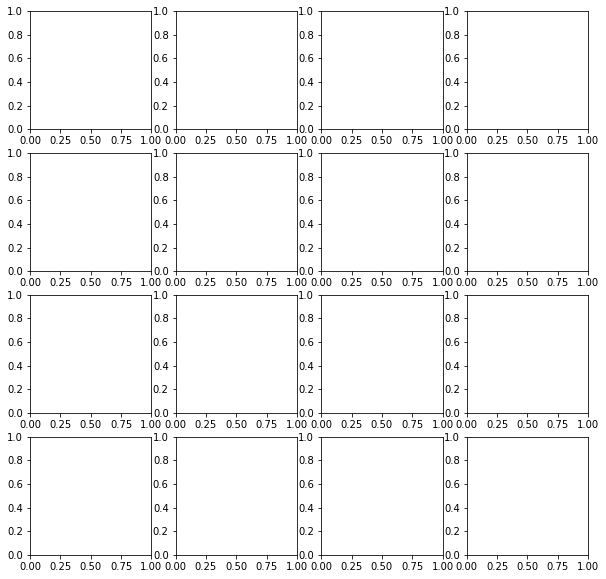

In [ ]:
col1 = 'orange'
col2 = 'lightskyblue'
col3 = 'firebrick'
col4 = 'royalblue'

label_chainA = "WMAP"
label_chainB = "BAO (Cooke et al. 17)"
label_chainAB = "WMAP+BAO"
label_chainBA = "BAO+WMAP"
label_impsamp = "imp. sampling"

fig, axes = plt.subplots(nparams, nparams, figsize=(10,10))

#plot the base contours
plot_contours(np.array(par_A).T, fig, axes, col1, "WMAP", None)
plot_contours(np.array(par_B).T, fig, axes, col2, "BAO (Cooke et al. 2017)", None)

## Get the re-weighted contours

In [ ]:
plot_contours(np.array(par_A).T, fig, axes, col2, "BAO+WMAP", weights_B)
plot_contours(np.array(par_B).T, fig, axes, col2, "BAO+WMAP", weights_B)

## Get the importance sampling final contours

In [ ]:
plot_contours(np.array(joined_sample).T, fig, axes, 'k', "Importance sampling", final_weights)